Using some of the info captured in the quick_exploratory_data_analysis, we are going to work on an model that satisfies the project requirements.

Summary of the data set 'feature_frame_csv':

- Per each order, we have a set of rows representing all the products that exist in the supermarket at that moment. Each row has relevant information about the product that represents. 
- The relevant information about the product is the following one
    - 'outcome'
    - 'ordered_before'
    - 'abandoned_before'
    - 'active_snoozed'
    - 'set_as_regular'
    
All of them are boolean

- In fact, the most important variable is outcome, because is the one we are going to use as the unknown of our problem.

- We are going to make the following assumptions to work with our problem:
    - We are going to find a way to predict if some product is going to be bought in the next order of a client.
    - We are going to test with the outcome label from that next order
    - If we guess correctly, we are going to assume that a recommendation here would have fit well

Business note: The most important variable here would be to know if a product has been recommended or not in each order. With that variable, our program would be much stronger that anything we could do with the info we have now.  

The sales team wants push notifications only in the orders with more than 4 items. As we have seen previously, a relevant fraction of the orders doesn't match this requirement. We are going to filter in order to work only with the purchase with more than 4 items, in order to make the things easier.

However, with this we are going to loose a huge quantity of information. Moreover, one idea that comes to my mind is that, in fact, little purchases can be the most relevant in this problem. Sometimes you make an order and you forget a few extremely relevant items, so just after that you make a small fast order completing the previous one. Some good recommendation would have solved that problem to the customer, and the company would have paid only for preparing and sending an only order.

A much better solution would have used the hole data set, giving a much complex solution. After that, we should put a restriction on the push notifications, allowing them to appear only when the user have more than 4 items on his cart.


Let's start to work on our model.

In [180]:
%reset -f

In [181]:
from datetime import datetime
import os
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 

In [182]:
cwd = os.getcwd()
r_path = '/../../Data/'
file = 'feature_frame.csv'
path = cwd + r_path + file
df_orders = pd.read_csv(path)

In [183]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

[ 0.  0.  0. ... 53. 53. 78.]


Text(0.5, 1.0, 'Histogram of the size of the orders')

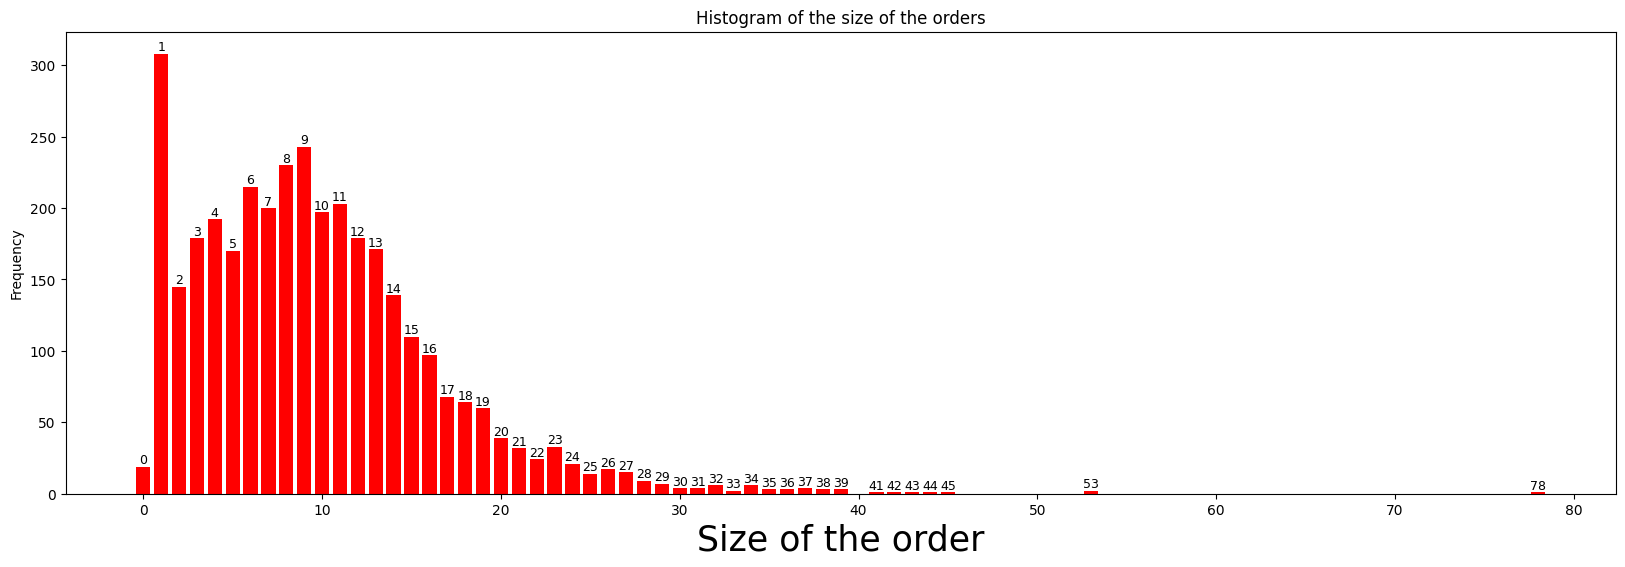

In [184]:
purchase_size = df_orders.groupby('order_id')['outcome'].sum().sort_values()
print(purchase_size.values)

purchase_size_unique, purchase_size_frec = np.unique(purchase_size, return_counts=True)

plt.figure(figsize=(20, 6))
plt.bar(purchase_size_unique, purchase_size_frec, color='red')

for i in range(len(purchase_size_frec)):
    plt.text(purchase_size_unique[i], purchase_size_frec[i], str(int(purchase_size_unique[i])), ha='center', va='bottom', fontsize = 9)


plt.xlabel('Size of the order', fontsize = 25)
plt.ylabel('Frequency')
plt.title('Histogram of the size of the orders')

There are some orders with no items at all (Weird)

In [185]:
df_orders_filtered = df_orders[df_orders['order_id'].isin(purchase_size[purchase_size>=5].index.values)]
print(f'Total number of observations: {len(df_orders)}')
print(f'Number of observations with orders with more than 5 items: {len(df_orders_filtered)}')
print('\n')
print(f'Total number of orders {len(df_orders.groupby("order_id").count())}')
print(f'Number of orders with more than 5 items: {len(df_orders_filtered.groupby("order_id").count())}')

Total number of observations: 2880549
Number of observations with orders with more than 5 items: 2163953


Total number of orders 3446
Number of orders with more than 5 items: 2603


In [186]:
# df_orders.columns

cols_name = ['variant_id','order_id','user_id'] 
cols_date = ['created_at','order_date']

cols_binary = ['ordered_before','abandoned_before','active_snoozed','set_as_regular']
cols_class = ['product_type','vendor']
cols_numeric = ['user_order_seq','normalised_price','discount_pct',
       'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type']

col_label = ['outcome']

In order to avoid information leakage, we are going to short the dataset by date. It's seems that the company make all the orders together at the end of every day, so we are going to use created_at to have more control of our data 

In [187]:
df_orders_filtered = df_orders_filtered.sort_values('created_at')
a = df_orders_filtered[['order_id','created_at','order_date']]

Text(0.5, 0, 'Date')

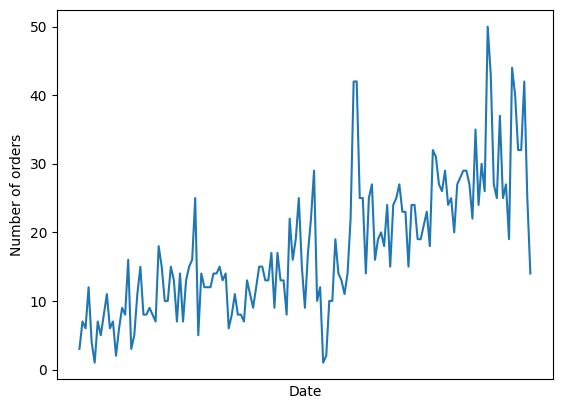

In [188]:
n_orders_big= df_orders_filtered.groupby('order_date')['order_id'].nunique()

plt.plot(n_orders_big)
plt.xticks([])

plt.ylabel('Number of orders')
plt.xlabel('Date')



In [189]:
train = 0.7
val = 0.85

size_df_orders_filtered = len(df_orders_filtered)

# The dataframe has been sorted
df_train = df_orders_filtered.iloc[:int(size_df_orders_filtered*train)]
df_val = df_orders_filtered.iloc[int(size_df_orders_filtered*train):int(size_df_orders_filtered*val)]
df_test = df_orders_filtered.iloc[int(size_df_orders_filtered*val):]

len(df_orders_filtered) == len(df_train)+len(df_val)+len(df_test)

True

From here on, the code doesn't work

In [190]:
# Baseline

Models

In [195]:
x_train_m1 = df_train[cols_binary]
y_train_m1 = df_train[col_label]

x_val_m1 = df_val[cols_binary]
y_val_m1 = df_val[col_label]

In [ ]:
# Lasso
m1 = Lasso(alpha = 0.1).fit(x_train_m1,y_train_m1)

In [202]:
y_pred_m1 = m1.predict(x_val_m1)


/home/felixcope/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [ ]:
# Ridge